# Data Preparation
Import the data you need and perform necessary transformation

In [2]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

# Load your data
df = pd.read_csv("ohlcv.csv")

# Step 1: Drop rows with missing timestamps and sort by datetime
df.dropna(subset=["start_time"], inplace=True)
df.sort_values(by="datetime", inplace=True)
df.set_index("datetime", inplace=True)

In [3]:
df

,start_time,close,high,low,open,volume
datetime,,,,,,
2024-01-01 00:00:00,1704067200000,42475.23,42554.57,42261.02,42283.58,1271.68108
2024-01-01 01:00:00,1704070800000,42613.56,42775.00,42431.65,42475.23,1196.37856
2024-01-01 02:00:00,1704074400000,42581.10,42638.41,42500.00,42613.57,685.21980
2024-01-01 03:00:00,1704078000000,42330.49,42586.64,42230.08,42581.09,794.80391
2024-01-01 04:00:00,1704081600000,42399.99,42399.99,42209.46,42330.50,715.41760
...,...,...,...,...,...,...
2024-12-31 19:00:00,1735671600000,94166.88,94290.91,93712.45,93875.69,462.79342
2024-12-31 20:00:00,1735675200000,93564.04,94222.50,93450.17,94166.88,733.04147
2024-12-31 21:00:00,1735678800000,93899.68,93964.15,93504.67,93564.01,337.52715


# Feature Engineering
Create features based on your need.

In [5]:
# Step 2: Create features (assuming 1-hour data and 4-hour window)
window = 4 # in hours
derived_features = ["log_return", "volatility", "momentum", "zscore"]

df["log_return"] = np.log(df["close"] / df["close"].shift(1))
df["volatility"] = df["log_return"].rolling(window).std()
df["momentum"] = df["close"] / df["close"].shift(window) - 1
df["zscore"] = (df["close"] - df["close"].rolling(window).mean()) / df["close"].rolling(window).std()

# Step 3: Keep only relevant columns
df = df[["close"] + derived_features].dropna()

In [6]:
df

,close,log_return,volatility,momentum,zscore
datetime,,,,,
2024-01-01 04:00:00,42399.99,0.001640,0.003996,-0.001771,-0.590773
2024-01-01 05:00:00,42234.01,-0.003922,0.003341,-0.008907,-1.039746
2024-01-01 06:00:00,42396.69,0.003844,0.004582,-0.004331,0.725311
2024-01-01 07:00:00,42492.46,0.002256,0.003381,0.003826,1.039305
2024-01-01 08:00:00,42549.99,0.001353,0.003365,0.003538,0.953201
...,...,...,...,...,...
2024-12-31 19:00:00,94166.88,0.003097,0.004778,-0.013050,-0.213567
2024-12-31 20:00:00,93564.04,-0.006422,0.004909,-0.013749,-1.330139
2024-12-31 21:00:00,93899.68,0.003581,0.004799,-0.002351,0.093700


# Train the model

In [28]:
# Step 4: Prepare input features and scale them
from hmmlearn.hmm import GaussianHMM

scaler = StandardScaler()

train_df = df.iloc[:6000]
test_df = df.iloc[6000:]

scaler = StandardScaler()

train_features = train_df[derived_features]
X_train = scaler.fit_transform(train_features)

test_features = test_df[derived_features]
X_test = scaler.transform(test_features)

model = GaussianHMM(n_components=4, covariance_type="full", n_iter=100, random_state=42).fit(X_train)
model

GaussianHMM(covariance_type='full', n_components=4, n_iter=100, random_state=42)

In [9]:
# Step 6: Predict regimes
regimes = model.predict(X_train)

# Step 7: Append regime back to a new DataFrame with original data
train_regime = pd.DataFrame(X_train, columns=derived_features, index=train_df.index)
train_regime["regime"] = regimes

# Check result
print("\nRegime counts:")
train_regime["regime"].value_counts()


Regime counts:


regime
1    2292
0    1425
2    1362
3     921
Name: count, dtype: int64

In [10]:
train_regime.groupby("regime")[["log_return", "volatility", "momentum", "zscore"]].mean()

,log_return,volatility,momentum,zscore
regime,,,,
0,-0.405093,0.017335,-0.503666,-0.826955
1,-0.006563,-0.710712,0.002234,-0.019745
2,0.458868,-0.023789,0.605558,0.929633
3,-0.035483,1.777036,-0.121787,-0.046139


In [11]:
regime_labels = {
    0: "bullish",
    1: "volatile",
    2: "bearish",
    3: "sideways"
}
train_regime["regime_label"] = train_regime["regime"].map(regime_labels)
train_regime

,log_return,volatility,momentum,zscore,regime,regime_label
datetime,,,,,,
2024-01-01 04:00:00,0.276018,-0.160748,-0.174275,-0.654802,0,bullish
2024-01-01 05:00:00,-0.683342,-0.342690,-0.797687,-1.127915,0,bullish
2024-01-01 06:00:00,0.656115,0.002171,-0.397887,0.732040,2,bearish
2024-01-01 07:00:00,0.382229,-0.331512,0.314790,1.062916,2,bearish
2024-01-01 08:00:00,0.226431,-0.336075,0.289577,0.972183,2,bearish
...,...,...,...,...,...,...
2024-09-06 23:00:00,1.015484,2.107116,0.680118,0.858538,3,sideways
2024-09-07 00:00:00,-0.163476,1.110218,1.675416,0.637070,3,sideways
2024-09-07 01:00:00,-0.329097,-0.201170,0.056537,-0.183475,1,volatile


In [12]:
# Get the soft state membership probabilities
posterior_probs = model.predict_proba(X_train)  # shape: (n_samples, n_components)

# Create column names for each state
proba_columns = [f"prob_state_{i}" for i in range(model.n_components)]

# Create a DataFrame from the probabilities
posterior_df = pd.DataFrame(posterior_probs, columns=proba_columns, index=train_regime.index)

# Concatenate with your original df_regime
train_regime = pd.concat([train_regime, posterior_df], axis=1)

# Show the result
train_regime.head()

,log_return,volatility,momentum,zscore,regime,regime_label,prob_state_0,prob_state_1,prob_state_2,prob_state_3
datetime,,,,,,,,,,
2024-01-01 04:00:00,0.276018,-0.160748,-0.174275,-0.654802,0,bullish,1.000000e+00,1.761355e-192,0.000000e+00,2.068002e-245
2024-01-01 05:00:00,-0.683342,-0.342690,-0.797687,-1.127915,0,bullish,9.997496e-01,1.314624e-04,3.941643e-12,1.189548e-04
2024-01-01 06:00:00,0.656115,0.002171,-0.397887,0.732040,2,bearish,1.026889e-01,1.172682e-03,8.945048e-01,1.633576e-03
2024-01-01 07:00:00,0.382229,-0.331512,0.314790,1.062916,2,bearish,1.625749e-06,1.590060e-01,8.409796e-01,1.278246e-05
2024-01-01 08:00:00,0.226431,-0.336075,0.289577,0.972183,2,bearish,7.055604e-07,3.068140e-01,6.931772e-01,8.030369e-06


# Creating Pipeline

In [14]:
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np

class Strategy(ABC):
    @abstractmethod
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        pass

In [15]:
class HMMRegimeStrategy(Strategy):
    def __init__(self, model, regime_labels: dict):
        self.model = model
        self.regime_labels = regime_labels

    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        features = data[["log_return", "volatility", "momentum", "zscore"]]
        scaler = StandardScaler()
        X = scaler.fit_transform(features)
        
        posterior_probs = self.model.predict_proba(X)
        regimes = self.model.predict(X)
    
        n = len(data)
        signals = np.zeros(n, dtype=int)
        label_to_id = {v: k for k, v in self.regime_labels.items()}
        
    
        for i in range(n):
            current = regimes[i]
            current_label = self.regime_labels[current]
            state_probs = posterior_probs[i]
    
            if current_label == "bullish" and (
                state_probs[label_to_id.get("bullish", -1)] > 0.6 or
                state_probs[label_to_id.get("volatile", -1)] > 0.7):
                signals[i] = 1  # long
            
    
            elif current_label == "bearish" and (
                state_probs[label_to_id.get("bearish", -1)] > 0.6 or
                state_probs[label_to_id.get("sideways", -1)] > 0.7):
                signals[i] = -1  # short
    
        return pd.Series(signals, index=data.index)

In [16]:
import pandas as pd
from collections import deque

class SmartHMMStrategy(HMMRegimeStrategy):
    def __init__(self, model, regime_labels, debounce=3, trans_thresh=0.5):
        super().__init__(model, regime_labels)
        self.debounce = debounce
        self.trans_thresh = trans_thresh

    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        features = data[["log_return","volatility","momentum","zscore"]]
        X = StandardScaler().fit_transform(features)
        post = self.model.predict_proba(X)
        trans = self.model.transmat_
        window = deque(maxlen=self.debounce)
        signals = []
        for i in range(len(data)):
            window.append(post[i])
            avg_prob = sum(window) / len(window)
            curr_state = np.argmax(avg_prob)
            next_prob = trans[curr_state].max()
            # require both smoothed posterior AND transition strength
            if avg_prob[curr_state] > 0.6 and next_prob > self.trans_thresh:
                signals.append(1 if self.regime_labels[curr_state]=="bullish" else -1)
            else:
                signals.append(0)
        return pd.Series(signals, index=data.index)

In [17]:
from typing import Union, Optional, Dict
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

class Backtester:
    def __init__(
        self,
        data: Union[pd.DataFrame, pd.Series],
        positions: Optional[pd.Series] = None,
        trade_fee: float = 0.0005
    ):
        # Normalize input:
        if isinstance(data, pd.Series):
            # Single series of close prices
            self.data = pd.DataFrame({'close': data})
            if positions is None:
                raise ValueError("Positions series must be provided when passing a Series of close prices.")
            self.data['positions'] = positions
        else:
            # Full DataFrame
            self.data = data.copy()
            if positions is not None:
                self.data['positions'] = positions
            elif 'positions' not in self.data:
                raise ValueError("Positions must be in the DataFrame or passed explicitly.")

        self.trade_fee = trade_fee

    def run(self) -> pd.DataFrame:
        df = self.data.copy()
        # 1) Price change
        df['price_change'] = df['close'].pct_change().fillna(0)
        # 2) Previous position and trades
        df['prev_pos'] = df['positions'].shift(1).fillna(0)
        df['trades'] = (df['positions'] - df['prev_pos']).abs()
        # 3) Raw PnL
        df['pnl_raw'] = df['prev_pos'] * df['price_change']
        # 4) Trade cost
        df['trade_cost'] = df['trades'] * self.trade_fee
        # 5) Net PnL
        df['pnl'] = df['pnl_raw'] - df['trade_cost']
        # 6) Equity curve
        df['equity'] = df['pnl'].cumsum()
        # 7) Rolling max drawdown
        rolling_max = df['equity'].cummax()
        df['max_dd'] = df['equity'] - rolling_max
        # 8) Metrics
        sharpe = np.nan_to_num(df['pnl'].mean() / df['pnl'].std(), nan=0.0)
        max_dd_value = df['max_dd'].min()
        trade_freq_pct = df['trades'].sum() / len(df) * 100
        print(f"Sharpe Ratio        : {sharpe:.4f}")
        print(f"Max Drawdown (%)    : {max_dd_value * 100:.4f}")
        print(f"Trade Frequency (%) : {trade_freq_pct:.2f}")

        self._plot_close_equity_graph(df)
        self._plot_close_maxdd_graph(df)
        self._plot_close_equity_maxdd_graph(df)

        return df[['close', 'positions', 'trades', 'pnl', 'equity', 'max_dd']]

    def _plot_close_equity_graph(self, df: pd.DataFrame):
        x = df.index
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=df['close'],  name='Close'))
        fig.add_trace(go.Scatter(x=x, y=df['equity'], name='Equity', yaxis='y2'))

        fig.update_layout(
            title='Close vs. Equity',
            xaxis_title='Date',
            yaxis=dict(title='Close Price'),
            yaxis2=dict(title='Equity',
                        overlaying='y', side='right'),
            legend=dict(x=0.02, y=0.98),
            width=900, height=500
        )

        fig.show()

    def _plot_close_maxdd_graph(self, df: pd.DataFrame):
        x = df.index

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=df['close'],    name='Close'))
        fig.add_trace(go.Scatter(x=x, y=df['max_dd'],   name='Max Drawdown', yaxis='y2'))
        
        fig.update_layout(
            title='Close vs. Max Drawdown',
            xaxis_title='Date',
            yaxis=dict(title='Close Price'),
            yaxis2=dict(title='Drawdown',
                        overlaying='y', side='right'),
            legend=dict(x=0.02, y=0.98),
            width=900, height=500
        )
        
        fig.show()

    def _plot_close_equity_maxdd_graph(self, df: pd.DataFrame):
        x = df.index
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=df['close'],      name='Close'))
        fig.add_trace(go.Scatter(x=x, y=df['equity'],     name='Equity',       yaxis='y2'))
        fig.add_trace(go.Scatter(x=x, y=df['max_dd'],     name='Max Drawdown', yaxis='y2',
                                  line=dict(dash='dash')))
        
        fig.update_layout(
            title='Close vs Equity & Max Drawdown',
            xaxis_title='Date',
            yaxis=dict(title='Close Price'),
            yaxis2=dict(title='Equity / Drawdown',
                        overlaying='y', side='right'),
            legend=dict(x=0.02, y=0.98),
            width=900, height=500
        )
        
        fig.show()


In [18]:
from typing import Any
import pandas as pd

class EasyPipeline:
    def __init__(
        self,
        data: pd.DataFrame,
        strategy: Any,
        trade_fee: float = 0.0005
    ):
        # Validate data type
        if not isinstance(data, pd.DataFrame):
            raise ValueError("`data` must be a pandas DataFrame.")
        # Ensure a 'close' column exists (or rename 'close_price')
        if 'close' not in data.columns:
            if 'close_price' in data.columns:
                data = data.rename(columns={'close_price': 'close'})
            else:
                raise ValueError("`data` must contain a 'close' or 'close_price' column.")
        self.data = data.copy()
        self.strategy = strategy
        self.trade_fee = trade_fee

        # Pre-generate and validate signals as positions
        positions = self.strategy.generate_signals(self.data)
        if not isinstance(positions, pd.Series):
            raise ValueError("Signals must be returned as a pandas Series.")
        invalid = set(positions.unique()) - {-1, 0, 1}
        if invalid:
            raise ValueError(f"Signals may only contain -1, 0, or 1; found {invalid}.")
        # Align index
        positions = positions.reindex(self.data.index).fillna(0).astype(int)
        self.positions = positions

    def run_pipeline(self) -> pd.DataFrame:
        # Run the backtest using pre-validated data & positions
        bt = Backtester(self.data, self.positions, trade_fee=self.trade_fee)
        return bt.run()


Sharpe Ratio        : -0.0245
Max Drawdown (%)    : -37.7981
Trade Frequency (%) : 29.82


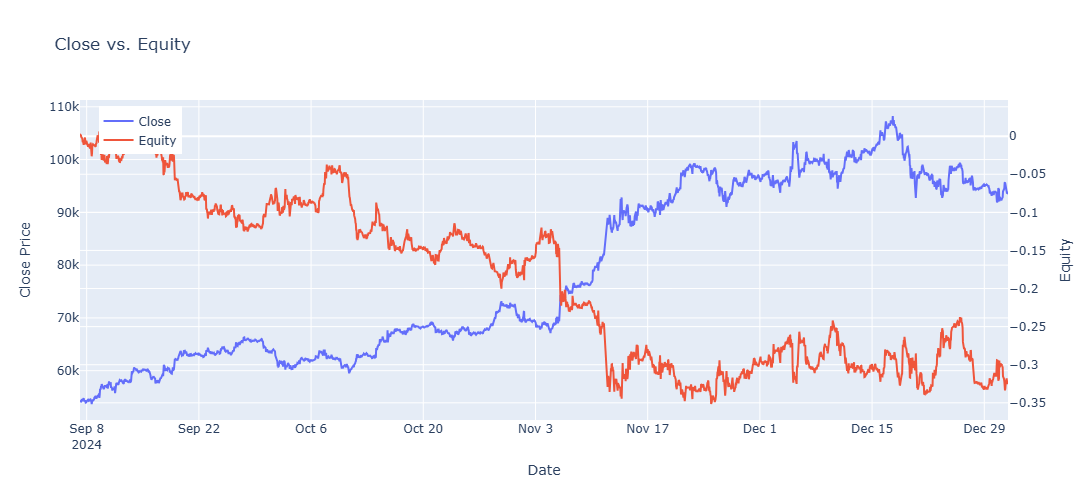

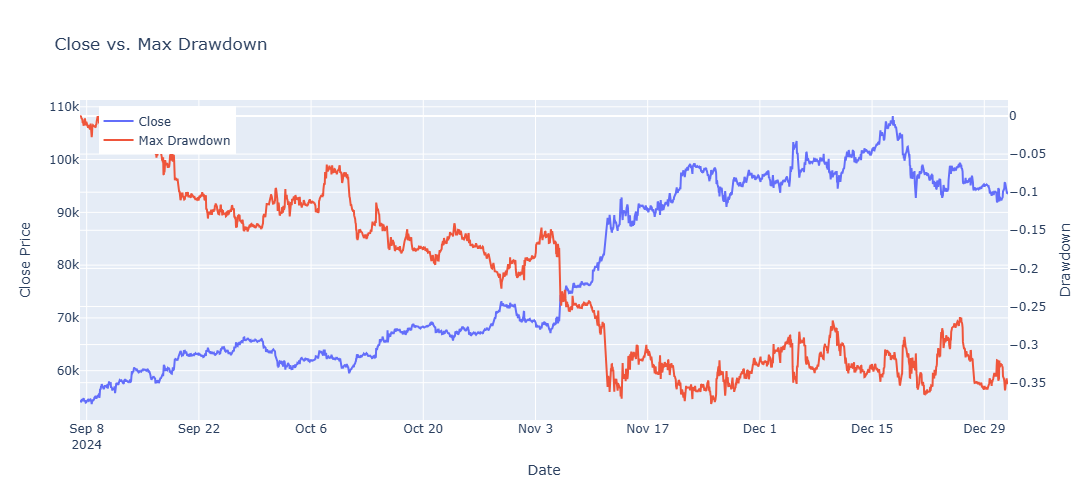

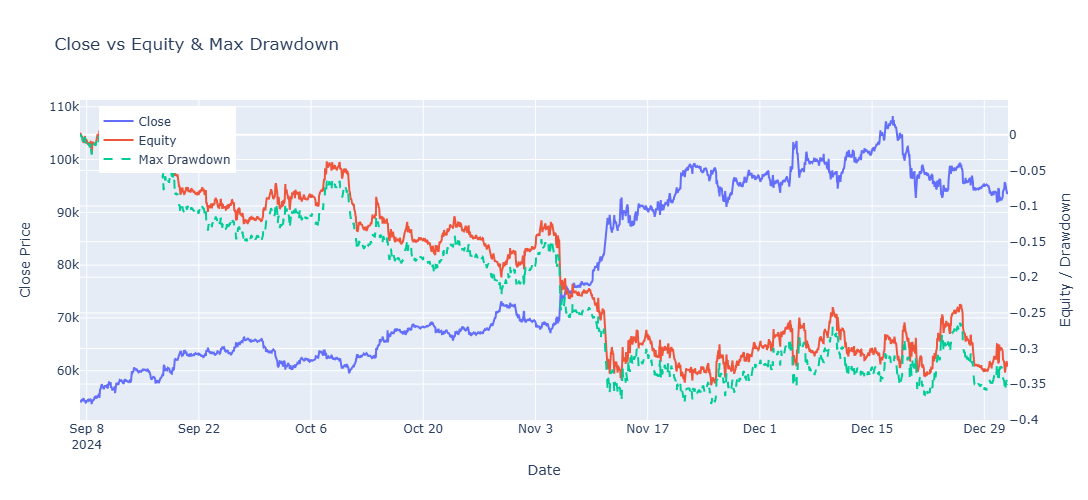

,close,positions,trades,pnl,equity,max_dd
datetime,,,,,,
2024-09-07 04:00:00,54060.59,1,1.0,-0.000500,-0.000500,0.000000
2024-09-07 05:00:00,54185.01,0,1.0,0.001801,0.001301,0.000000
2024-09-07 06:00:00,54320.23,0,0.0,0.000000,0.001301,0.000000
2024-09-07 07:00:00,54286.00,-1,1.0,-0.000500,0.000801,-0.000500
2024-09-07 08:00:00,54370.99,0,1.0,-0.002066,-0.001264,-0.002566
2024-09-07 09:00:00,54251.11,-1,1.0,-0.000500,-0.001764,-0.003066
2024-09-07 10:00:00,54346.01,-1,0.0,-0.001749,-0.003513,-0.004815
2024-09-07 11:00:00,54326.00,-1,0.0,0.000368,-0.003145,-0.004447
2024-09-07 12:00:00,54578.71,-1,0.0,-0.004652,-0.007797,-0.009098


In [30]:
EasyPipeline(test_df, SmartHMMStrategy(model, regime_labels)).run_pipeline().head(50)